In [11]:
import pandas as pd
import itertools 
import numpy as np
from itertools import product
from tqdm import tqdm
 
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout 
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.callbacks import EarlyStopping


from prophet import Prophet

import warnings
warnings.filterwarnings("ignore")
import os


In [2]:
RAW_DATA_PATH = "/home/nuh/PycharmProjects/StockAgent/data"
DATA_PATH = "/home/nuh/PycharmProjects/StockAgent/dev_v_04/data"
MODEL_PATH = "/home/nuh/PycharmProjects/StockAgent/dev_v_04/models"

# Sentetik Verileri Oluştur

In [6]:


# Orijinal ürünleri yükle
products_df = pd.read_csv(f"{RAW_DATA_PATH}/products.csv")

# Sabit renk listesi
renkler = ["Siyah", "Beyaz", "Kırmızı", "Mavi", "Yeşil"]

# Kategorilere özel beden listeleri
beden_map = {
    "Çocuk Giyim": ["XS", "S", "M"],
    "Kadın Giyim": ["S", "M", "L", "XL"],
    "Erkek Giyim": ["S", "M", "L", "XL"]
}

varyant_listesi = []

for _, row in products_df.iterrows():
    product_id = row["product_id"]
    category = row["category"]
    subcategory = row["subcategory"]

    # Bedenleri kategoriye göre seç
    mevcut_bedenler = beden_map.get(category, ["S", "M", "L"])
    
    # 2–3 rastgele renk ve beden seç
    selected_colors = pd.Series(renkler).sample(3, random_state=product_id).tolist()
    selected_sizes = pd.Series(mevcut_bedenler).sample(3, random_state=product_id + 100).tolist()

    for color, size in itertools.product(selected_colors, selected_sizes):
        varyant_listesi.append({
            "product_id": product_id,
            "category": category,
            "subcategory": subcategory,
            "color": color,
            "size": size
        })

# Yeni dataframe
products_variants_df = pd.DataFrame(varyant_listesi)

# Kaydetmek istersen
products_variants_df.to_csv(f"{DATA_PATH}/products_with_variants.csv", index=False)

# Örnek çıktı
print(products_variants_df.head(10))


   product_id     category subcategory    color size
0           1  Çocuk Giyim        Body  Kırmızı    M
1           1  Çocuk Giyim        Body  Kırmızı   XS
2           1  Çocuk Giyim        Body  Kırmızı    S
3           1  Çocuk Giyim        Body    Beyaz    M
4           1  Çocuk Giyim        Body    Beyaz   XS
5           1  Çocuk Giyim        Body    Beyaz    S
6           1  Çocuk Giyim        Body    Yeşil    M
7           1  Çocuk Giyim        Body    Yeşil   XS
8           1  Çocuk Giyim        Body    Yeşil    S
9           2  Kadın Giyim        Bluz  Kırmızı    M


## Varyanlı Ürünler

In [5]:
import pandas as pd
import numpy as np
from tqdm import tqdm

# === 1. VARYANTLI ÜRÜNLERİ YÜKLE ===
products_df = pd.read_csv(f"{DATA_PATH}/products_with_variants.csv")

# === 2. PARAMETRELER ===
kanallar = ["Fiziksel", "Online"]
magaza_sayisi = 50
tarihler = pd.date_range(start="2022-01-01", end="2024-12-31", freq="D")

# === 3. SATIŞ VERİSİ ÜRETİMİ ===
sales_list = []
np.random.seed(42)

for _, row in tqdm(products_df.iterrows(), total=len(products_df), desc="Ürün Varyantları"):
    for date in tarihler:
        month = date.month
        dayofweek = date.dayofweek
        season_multiplier = 1.2 if month in [6, 7, 8] else (0.8 if month in [12, 1, 2] else 1.0)
        weekend_multiplier = 1.3 if dayofweek >= 5 else 1.0

        # 1 mağaza rastgele seç
        store_id = np.random.randint(0, magaza_sayisi)
        # Kanal rastgele seç
        channel = np.random.choice(kanallar)

        # Alt kategori bazlı temel satış ortalaması
        if row["subcategory"] in ["Tişört", "Bluz"]:
            base = 5
        elif row["subcategory"] in ["Gömlek", "Tayt"]:
            base = 3
        elif row["subcategory"] in ["Sweatshirt", "Pantolon"]:
            base = 2
        else:
            base = 1

        channel_multiplier = 0.8 if channel == "Online" else 1.0

        # Gürültülü satış
        noise = np.random.poisson(base)
        noise += np.random.normal(5, 5)
        noise += np.random.randint(2, 6)  # min 1 ek gürültü

        final_sales = max(0, int(noise * season_multiplier * weekend_multiplier * channel_multiplier))

        sales_list.append({
            "date": date,
            "store_id": store_id,
            "product_id": row["product_id"],
            "color": row["color"],
            "size": row["size"],
            "channel": channel,
            "sales": final_sales
        })

# === 4. VERİ SETİNE DÖNÜŞTÜR ===
sales_df = pd.DataFrame(sales_list)
print(f"Toplam satır sayısı: {len(sales_df):,}")

# === 5. KAYDET (isteğe bağlı) ===
sales_df.to_csv(f"{DATA_PATH}/sales_data_v2_by_product.csv", index=False)

# === 6. ÖRNEK GÖSTER ===
print(sales_df.sample(10))


Ürün Varyantları: 100%|██████████| 270/270 [00:03<00:00, 70.47it/s]


Toplam satır sayısı: 295,920
             date  store_id  product_id  color size   channel  sales
40820  2022-09-26        39           5  Yeşil   XL  Fiziksel     18
60708  2023-03-05        48           7  Siyah    M    Online     13
291570 2022-02-04        39          30  Beyaz   XL  Fiziksel     19
204199 2022-12-10        36          21  Siyah   XS  Fiziksel     10
39049  2023-11-21        38           4  Beyaz   XL  Fiziksel     16
84080  2024-02-24        33           9  Siyah   XL  Fiziksel     18
247124 2023-06-09        15          26  Yeşil   XS    Online      7
120036 2023-07-27         6          13  Beyaz    L  Fiziksel     10
112420 2023-09-21         3          12  Beyaz    M    Online      6
175969 2023-09-02        40          18  Siyah    L  Fiziksel      8


## Kampanyaları Düzenler

In [6]:
sales_df = pd.read_csv(f"{DATA_PATH}/sales_data_v2_by_product.csv", parse_dates=["date"])
products_df = pd.read_csv(f"{DATA_PATH}/products_with_variants.csv")
campaigns_df = pd.read_csv(f"{RAW_DATA_PATH}/campaigns.csv", parse_dates=["start_date", "end_date"])

# Ürün bilgisi ekle
sales_df = sales_df.merge(products_df, on=["product_id", "color", "size"], how="left")

# Kampanya eşleştirme için key oluştur
sales_df["key"] = 1
campaigns_df["key"] = 1
campaign_cross = pd.merge(sales_df, campaigns_df, on="key").drop("key", axis=1)

# Tarih eşleşmesini uygula
campaign_cross = campaign_cross[
    (campaign_cross["date"] >= campaign_cross["start_date"]) &
    (campaign_cross["date"] <= campaign_cross["end_date"])
]

# En yüksek indirimli kampanyayı seç
campaign_cross = campaign_cross.sort_values(
    ["date", "product_id", "discount"], ascending=[True, True, False]
).drop_duplicates(
    subset=["date", "product_id", "store_id", "channel"]
)

# Kampanya bilgilerini satışa ekle
sales_df = sales_df.merge(
    campaign_cross[["date", "product_id", "store_id", "channel", "discount", "type"]],
    on=["date", "product_id", "store_id", "channel"],
    how="left"
)

# Kampanya var mı?
sales_df["is_campaign"] = sales_df["discount"].notnull().astype(int)
sales_df["discount"] = sales_df["discount"].fillna(0)

# Kaydet
sales_df.to_csv(f"{DATA_PATH}/sales_data_v2_with_campaigns.csv", index=False)


# Train / Test Verilerini Hazırla

## XGBoost İçin Verileri Oluştur

In [7]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import numpy as np

# 1. VERİYİ YÜKLE
df = pd.read_csv(f"{DATA_PATH}/sales_data_v2_with_campaigns.csv", parse_dates=["date"])

# 2. ZAMAN ÖZNİTELİKLERİ (sin/cos)
df["dayofweek"] = df["date"].dt.dayofweek
df["month"] = df["date"].dt.month
df["week"] = df["date"].dt.isocalendar().week.astype(int)

# Döngüsel dönüşüm
df["dayofweek_sin"] = np.sin(2 * np.pi * df["dayofweek"] / 7)
df["dayofweek_cos"] = np.cos(2 * np.pi * df["dayofweek"] / 7)
df["month_sin"] = np.sin(2 * np.pi * df["month"] / 12)
df["month_cos"] = np.cos(2 * np.pi * df["month"] / 12)
df["week_sin"] = np.sin(2 * np.pi * df["week"] / 52)
df["week_cos"] = np.cos(2 * np.pi * df["week"] / 52)

# 3. KATEGORİK DÖNÜŞÜMLER
label_cols = ["category", "subcategory", "color", "size", "channel", "type"]
encoders = {}

for col in label_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    encoders[col] = le

# 4. FİNAL ÖZNİTELİKLER
features = [
    "product_id", "store_id", "category", "subcategory",
    "color", "size", "channel", "is_campaign", "discount", "type",
    "dayofweek_sin", "dayofweek_cos", "month_sin", "month_cos", "week_sin", "week_cos"
]
target = "sales"

# 5. TRAIN / TEST AYRIŞIMI
train_df = df[df["date"] < "2024-01-01"]
test_df = df[df["date"] >= "2024-01-01"]

X_train = train_df[features]
y_train = train_df[target]
X_test = test_df[features]
y_test = test_df[target]

# 6. KAYDET
X_train.to_csv(f"{DATA_PATH}/X_train.csv", index=False)
X_test.to_csv(f"{DATA_PATH}/X_test.csv", index=False)
y_train.to_csv(f"{DATA_PATH}/y_train.csv", index=False)
y_test.to_csv(f"{DATA_PATH}/y_test.csv", index=False)


## Prophet Verileri

In [9]:
import pandas as pd

# 1. Veriyi oku
df = pd.read_csv(f"{DATA_PATH}/sales_data_v2_with_campaigns.csv", parse_dates=["date"])

# 2. Prophet uyumlu sütun adları
df.rename(columns={"date": "ds", "sales": "y"}, inplace=True)

# 3. Regressor'lar (dilersen burada artırabilirsin)
regressors = ["is_campaign", "discount"]

# 4. Prophet çalışacağı tüm sütunlar
prophet_cols = ["ds", "y", "product_id", "color", "size"] + regressors

df = df[prophet_cols]

# 5. TRAIN - TEST BÖLME (örnek: 2022-2023 train, 2024 test)
df_train = df[df["ds"] < "2024-01-01"].copy()
df_test = df[df["ds"] >= "2024-01-01"].copy()

# 6. Prophet tarzı X/Y ayrımı (varyant bazlı kıyas için)
X_train = df_train[["ds"] + regressors + ["product_id", "color", "size"]]
y_train = df_train[["ds", "y", "product_id", "color", "size"]]

X_test = df_test[["ds"] + regressors + ["product_id", "color", "size"]]
y_test = df_test[["ds", "y", "product_id", "color", "size"]]

X_train.to_csv(f"{DATA_PATH}/prophet/X_train_prophet.csv", index=False)
X_test.to_csv(f"{DATA_PATH}/prophet/X_test_prophet.csv", index=False)
y_train.to_csv(f"{DATA_PATH}/prophet/y_train_prophet.csv", index=False)
y_test.to_csv(f"{DATA_PATH}/prophet/y_test_prophet.csv", index=False)

## LSTM Verileri

In [10]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

# === 1. VERİYİ YÜKLE ===
df = pd.read_csv(f"{DATA_PATH}/sales_data_v2_with_campaigns.csv", parse_dates=["date"])
df.rename(columns={"date": "ds", "sales": "y"}, inplace=True)

# === 2. LABEL ENCODING ===
label_cols = ["color", "size", "channel", "category", "subcategory", "type"]
label_encoders = {}
for col in label_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le

# === 3. ZAMAN SIRALAMASI ===
df = df.sort_values(["product_id", "color", "size", "ds"]).reset_index(drop=True)

# === 4. LSTM VERİSİ OLUŞTURAN FONKSİYON ===
def create_lstm_dataset_all(df, product_id, window_size=7, test_start="2024-01-01"):
    X, y, info = [], [], []
    regressors = ["is_campaign", "discount", "color", "size", "channel", "category", "subcategory", "type"]

    # Belirli ürünü filtrele
    df = df[df["product_id"] == product_id].copy()

    # Her varyant için sliding window ile veri üret
    for key, group in df.groupby(["color", "size"]):
        group = group.sort_values("ds").reset_index(drop=True)
        for i in range(window_size, len(group)):
            window = group.iloc[i - window_size:i]
            target = group.iloc[i]

            features = np.column_stack([
                window["y"].values,
                *[window[col].values for col in regressors]
            ])

            X.append(features)
            y.append(target["y"])
            info.append({
                "color": key[0],
                "size": key[1],
                "ds": target["ds"]
            })

    X = np.array(X)
    y = np.array(y)
    info_df = pd.DataFrame(info)

    # Test başlangıcına göre ayır
    is_test = info_df["ds"] >= pd.to_datetime(test_start)
    return {
        "X_train": X[~is_test],
        "y_train": y[~is_test],
        "X_test": X[is_test],
        "y_test": y[is_test],
        "test_info": info_df[is_test].reset_index(drop=True)
    }


In [11]:
product_id = 7  # Tahmin yapılacak ürün
data = create_lstm_dataset_all(df, product_id=product_id, window_size=7)

# Kaydet (opsiyonel)
np.save(f"{DATA_PATH}/lstm/lstm_data_product_7_w7_X_train.npy", data["X_train"])
np.save(f"{DATA_PATH}/lstm/lstm_data_product_7_w7_y_train.npy", data["y_train"])
np.save(f"{DATA_PATH}/lstm/lstm_data_product_7_w7_X_test.npy", data["X_test"])
np.save(f"{DATA_PATH}/lstm/lstm_data_product_7_w7_y_test.npy", data["y_test"])
data["test_info"].to_csv(f"{DATA_PATH}/lstm/lstm_data_product_7_w7_test_info.csv", index=False)


# Models

## LSTM

In [12]:


# === 1. VERİLERİ YÜKLE ===
product_id = 7
prefix = f"lstm_data_product_{product_id}_w7"

X_train = np.load(f"{DATA_PATH}/lstm/{prefix}_X_train.npy")
y_train = np.load(f"{DATA_PATH}/lstm/{prefix}_y_train.npy")
X_test = np.load(f"{DATA_PATH}/lstm/{prefix}_X_test.npy")
y_test = np.load(f"{DATA_PATH}/lstm/{prefix}_y_test.npy")
test_info = pd.read_csv(f"{DATA_PATH}/lstm/{prefix}_test_info.csv")

# === 2. MODELİ OLUŞTUR ===
model = Sequential()
model.add(LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

model.compile(optimizer='adam',loss = MeanSquaredError(),)

# === 3. EĞİT ===
model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=50,
    batch_size=32,
    verbose=1,
    callbacks=[
        EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        )
    ]
    
)

# === 4. TAHMİN YAP ===
y_pred = model.predict(X_test)

# === 5. DEĞERLENDİRME ===
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print(f"✅ RMSE: {rmse:.2f}")
print(f"✅ MAE:  {mae:.2f}")

# === 6. TAHMİN TABLOSUNU OLUŞTUR ===
result_df = test_info.copy()
result_df["y_true"] = y_test
result_df["y_pred"] = y_pred.flatten()

# === 7. KAYDET ===
result_df.to_csv(f"{MODEL_PATH}/lstm/{prefix}_forecast_results.csv", index=False)

# SAVE MODEL
model.save(f"{MODEL_PATH}/lstm/lstm_model_product_{product_id}.h5")


Epoch 1/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 81.4761 - val_loss: 35.8765
Epoch 2/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 33.9757 - val_loss: 35.7292
Epoch 3/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 32.7101 - val_loss: 35.0554
Epoch 4/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 32.6364 - val_loss: 35.7608
Epoch 5/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 33.4586 - val_loss: 34.9990
Epoch 6/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 32.4397 - val_loss: 34.7480
Epoch 7/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 31.7265 - val_loss: 35.0072
Epoch 8/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 31.5852 - val_loss: 34.7262
Epoch 9/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 31.3189 - val_loss: 35.0364
Epoch 10/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 31.6366 - val_loss: 35.6123
Epoch 11/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 32.4739 - val_loss: 35.8933
Epoch 12/50
183/183 ━━━━━━━━━━

✅ RMSE: 5.67
✅ MAE:  4.47


## Prophed

In [18]:


import joblib


def forecast_prophet_all_variants(df, product_id, test_start="2024-01-01", test_end="2024-12-31"):
    """
    Belirtilen ürünün tüm varyantları için Prophet forecast yapar.
    """
    df = df.rename(columns={"date": "ds", "sales": "y"}).copy()
    regressors = ["is_campaign", "discount"]
    results = []

    # Sadece ilgili ürünü al
    df = df[df["product_id"] == product_id]

    # Varyant bazında Prophet modeli eğit
    for (color, size), group in df.groupby(["color", "size"]):
        group = group.sort_values("ds")
        train_df = group[group["ds"] < test_start]
        test_df = group[(group["ds"] >= test_start) & (group["ds"] <= test_end)]

        if len(train_df) < 20 or len(test_df) == 0:
            continue  # veri yetersizse geç

        model = Prophet()
        for reg in regressors:
            model.add_regressor(reg)

        model.fit(train_df[["ds", "y"] + regressors])

        future = test_df[["ds"] + regressors].copy()
        forecast = model.predict(future)

        temp = pd.DataFrame({
            "ds": test_df["ds"].values,
            "color": color,
            "size": size,
            "y_true": test_df["y"].values,
            "y_pred": forecast["yhat"].values
        })

        results.append(temp)

    final = pd.concat(results, ignore_index=True)

    # RMSE/MAE
    rmse = np.sqrt(mean_squared_error(final["y_true"], final["y_pred"]))
    mae = mean_absolute_error(final["y_true"], final["y_pred"])


    print(f"✅ XGBoost RMSE: {rmse:.2f}")
    print(f"✅ XGBoost MAE:  {mae:.2f}")
 

    # Kaydet
    final.to_csv(f"{MODEL_PATH}/prophet/prophet_forecast_product_{product_id}.csv", index=False)
    

    joblib.dump(model, f"{MODEL_PATH}/prophet/prophet_model_product_{product_id}.pkl")
    print(f"✅ Prophet model saved: prophet_model_product_{product_id}.pkl")




In [19]:
df = pd.read_csv(f"{DATA_PATH}/sales_data_v2_with_campaigns.csv", parse_dates=["date"])
forecast_prophet_all_variants(df, product_id=7)


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcpu6kb_o/ne89113w.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcpu6kb_o/1x_ilftu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/home/nuh/PycharmProjects/StockAgent/.venv/lib/python3.12/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12458', 'data', 'file=/tmp/tmpcpu6kb_o/ne89113w.json', 'init=/tmp/tmpcpu6kb_o/1x_ilftu.json', 'output', 'file=/tmp/tmpcpu6kb_o/prophet_model016wxjb2/prophet_model-20250406200049.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:00:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:00:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:pro

✅ XGBoost RMSE: 5.64
✅ XGBoost MAE:  4.43
✅ Prophet model saved: prophet_model_product_7.pkl


## XGBoost

In [ ]:


# === 1. VERİYİ YÜKLE ===
df = pd.read_csv(f"{DATA_PATH}/sales_data_v2_with_campaigns.csv", parse_dates=["date"])
df = df[df["product_id"] == 7].copy()  # sadece istenen ürün

# === 2. ZAMAN ÖZNİTELİKLERİ ===
df["dayofweek"] = df["date"].dt.dayofweek
df["month"] = df["date"].dt.month
df["week"] = df["date"].dt.isocalendar().week.astype(int)

df["dayofweek_sin"] = np.sin(2 * np.pi * df["dayofweek"] / 7)
df["dayofweek_cos"] = np.cos(2 * np.pi * df["dayofweek"] / 7)
df["month_sin"] = np.sin(2 * np.pi * df["month"] / 12)
df["month_cos"] = np.cos(2 * np.pi * df["month"] / 12)
df["week_sin"] = np.sin(2 * np.pi * df["week"] / 52)
df["week_cos"] = np.cos(2 * np.pi * df["week"] / 52)

# === 3. KATEGORİK ENCODING ===
label_cols = ["color", "size", "channel", "category", "subcategory", "type"]
for col in label_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    
    if col == "color" or col == "size":
        joblib.dump(le, f"{MODEL_PATH}/sklearn/xgboost_label_encoder_{col}.pkl")

# === 4. ÖZELLİKLER ===
features = [ "color", "size", "channel", "category", "subcategory", "type",
    "is_campaign", "discount",
    "dayofweek_sin", "dayofweek_cos", "month_sin", "month_cos", "week_sin", "week_cos"
]
target = "sales"

# === 5. TRAIN / TEST BÖL ===
train_df = df[df["date"] < "2024-01-01"]
test_df = df[df["date"] >= "2024-01-01"]

X_train = train_df[features]
y_train = train_df[target]
X_test = test_df[features]
y_test = test_df[target]

# === 6. MODELİ EĞİT ===
model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6)
model.fit(X_train, y_train)

# === 7. TAHMİN + METRİKLER ===
y_pred = model.predict(X_test)

# === 5. DEĞERLENDİRME ===
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print(f"✅ XGBoost RMSE: {rmse:.2f}")
print(f"✅ XGBoost MAE:  {mae:.2f}")

# === 8. TAHMİN TABLOSU ===
result_df = test_df[["date", "color", "size"]].copy()
result_df["y_true"] = y_test.values
result_df["y_pred"] = y_pred
result_df.to_csv(f"{MODEL_PATH}/sklearn/xgboost_forecast_product_7.csv", index=False)

# === 9. KAYDET ===
#model.save_model(f"{MODEL_PATH}/sklearn/xgboost_model_product_7.json")
joblib.dump(model, f"{MODEL_PATH}/sklearn/xgboost_model_product_7.pkl")
print(f"✅ XGBoost model saved: xgboost_model_product_7.pkl")


✅ XGBoost RMSE: 5.41
✅ XGBoost MAE:  4.21
✅ XGBoost model saved: xgboost_model_product_7.pkl


# Eğitim Sonuçlarını Görselleştirme

In [22]:
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# === 1. Dosyaları Yükle ===
df_prophet = pd.read_csv(f"{MODEL_PATH}/prophet/prophet_forecast_product_7.csv")
df_lstm = pd.read_csv(f"{MODEL_PATH}/lstm/lstm_data_product_7_w7_forecast_results.csv")
df_xgb = pd.read_csv(f"{MODEL_PATH}/sklearn/xgboost_forecast_product_7.csv")

# === 2. RMSE / MAE Hesapla ===
def evaluate(df, name):
    rmse = np.sqrt(mean_squared_error(df["y_true"], df["y_pred"]))
    mae = mean_absolute_error(df["y_true"], df["y_pred"])
    return {"Model": name, "RMSE": round(rmse, 2), "MAE": round(mae, 2)}

results = [
    evaluate(df_prophet, "Prophet"),
    evaluate(df_lstm, "LSTM"),
    evaluate(df_xgb, "XGBoost")
]

# === 3. Sonuçları Tablo Olarak Göster ===
results_df = pd.DataFrame(results)
print(results_df)


     Model  RMSE   MAE
0  Prophet  5.64  4.43
1     LSTM  5.65  4.43
2  XGBoost  5.36  4.19


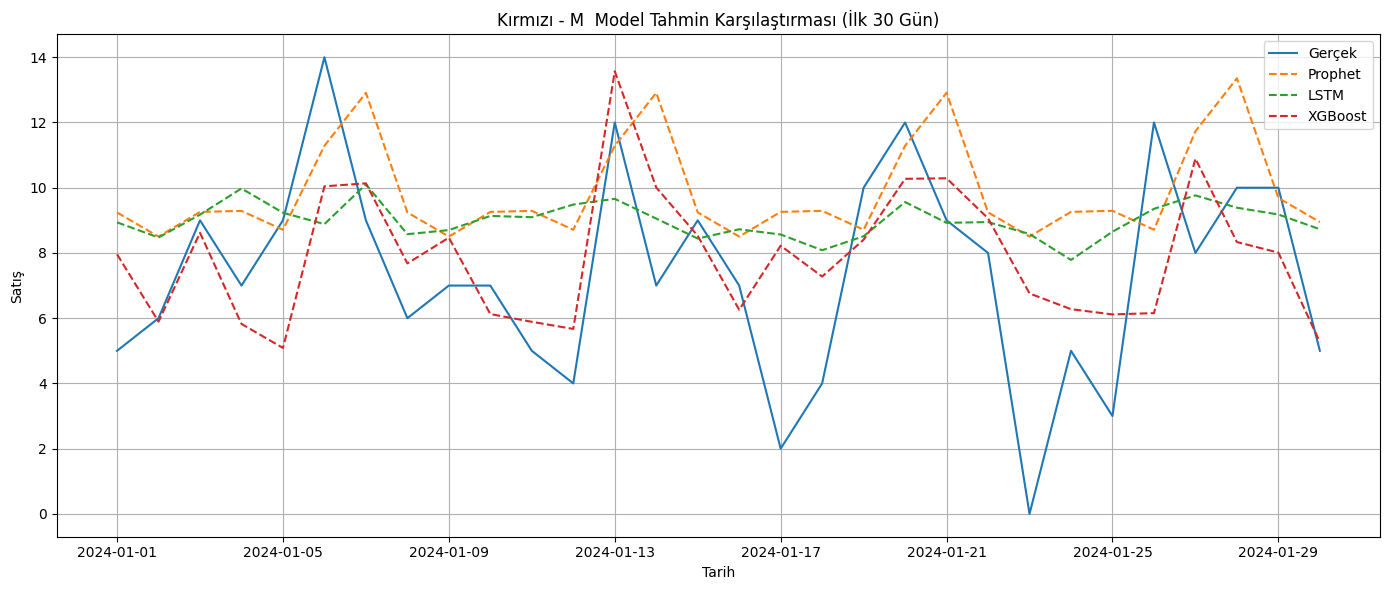

In [32]:
import matplotlib.pyplot as plt
import pandas as pd

# === 1. DOSYALARI YÜKLE ===
df_prophet = pd.read_csv(f'{MODEL_PATH}/prophet/prophet_forecast_product_7.csv')
df_lstm = pd.read_csv(f'{MODEL_PATH}/lstm/lstm_data_product_7_w7_forecast_results.csv')
df_xgb = pd.read_csv(f'{MODEL_PATH}/sklearn/xgboost_forecast_product_7.csv')

# === 2. TARİH DÖNÜŞÜMLERİ ===
df_prophet["ds"] = pd.to_datetime(df_prophet["ds"])
df_lstm["ds"] = pd.to_datetime(df_lstm["ds"])
df_xgb["date"] = pd.to_datetime(df_xgb["date"])

# === 3. İLK 30 GÜNÜ AL ===
df_prophet = df_prophet.iloc[:30]
df_lstm = df_lstm.iloc[:30]
df_xgb = df_xgb.iloc[:30]

# === 4. TEK GRAFİKTE 3 MODEL KARŞILAŞTIRMASI ===
plt.figure(figsize=(14, 6))

# Gerçek satışlar (aynı)
plt.plot(df_prophet['ds'], df_prophet['y_true'], label='Gerçek', linestyle='-')

# Tahminler
plt.plot(df_prophet['ds'], df_prophet['y_pred'], label='Prophet', linestyle='--')
plt.plot(df_lstm['ds'], df_lstm['y_pred'], label='LSTM', linestyle='--')
plt.plot(df_xgb['date'], df_xgb['y_pred'], label='XGBoost',  linestyle='--')

# Görselleştirme
plt.title(f'{df_prophet["color"][0]} - {df_prophet["size"][0]}  Model Tahmin Karşılaştırması (İlk 30 Gün)')
plt.xlabel('Tarih')
plt.ylabel('Satış')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Veri Keşfi ve Görselleştirme
Bu bölümde, üretilen verilerin farklı varyasyonlarını ve grafiklerini inceleyeceğiz.

/tmp/ipykernel_44418/4128560624.py:11: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=sales_data, x='date', y='sales', hue='channel', ci=None)


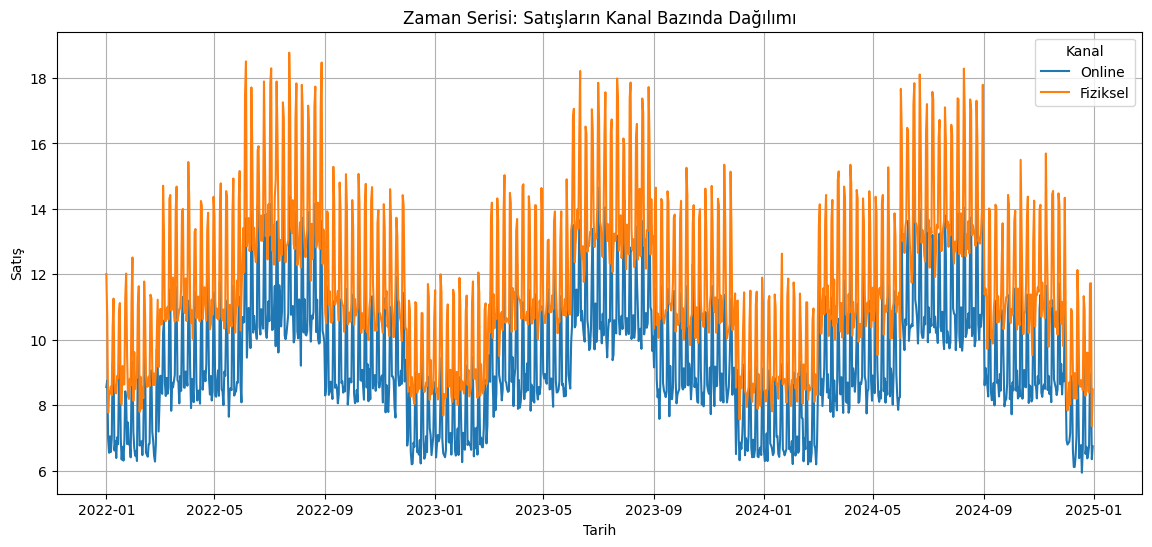

/tmp/ipykernel_44418/4128560624.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=sales_data, x='category', order=sales_data['category'].value_counts().index, palette='viridis')


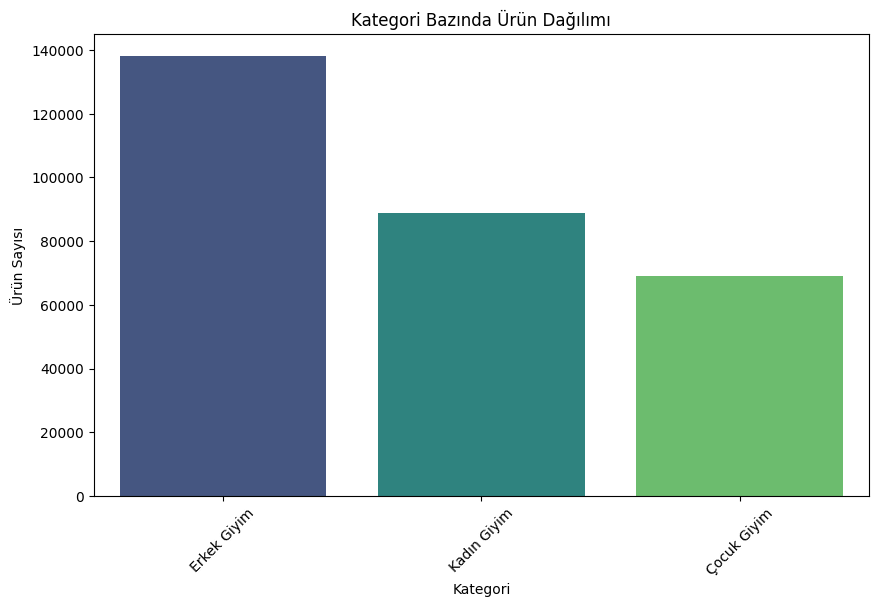

/tmp/ipykernel_44418/4128560624.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=monthly_sales, x='month', y='sales', palette='coolwarm')


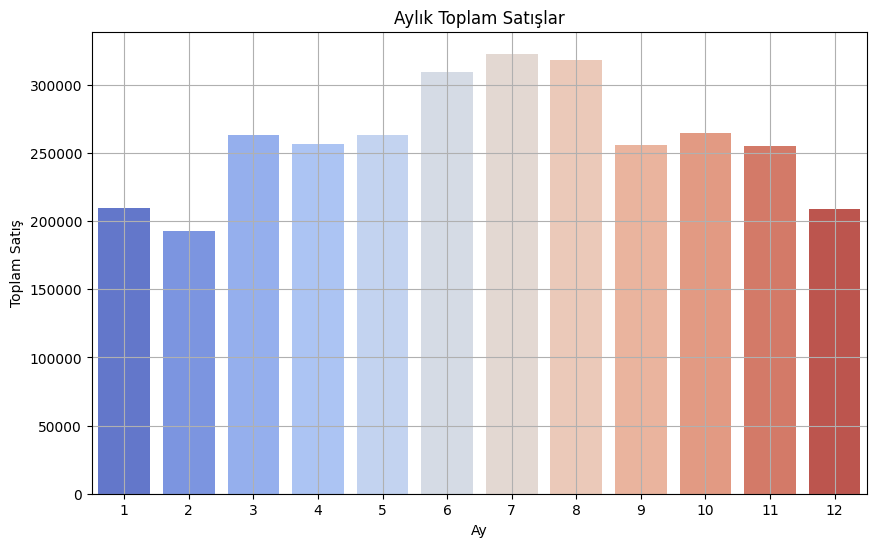

/tmp/ipykernel_44418/4128560624.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=sales_data, x='is_campaign', y='sales', palette='Set2')


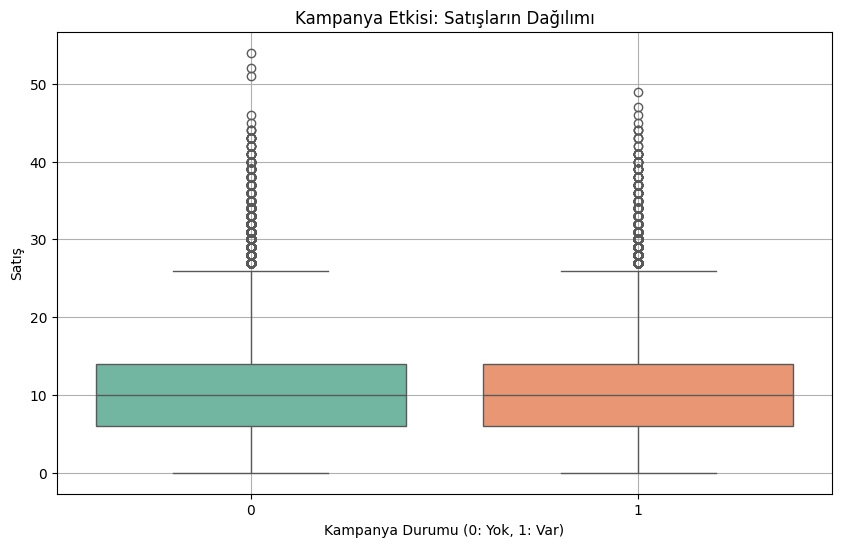

/tmp/ipykernel_44418/4128560624.py:51: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=sales_data, x='date', y='sales', hue='channel', ci=None)
/tmp/ipykernel_44418/4128560624.py:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=sales_data, x='category', order=sales_data['category'].value_counts().index, palette='viridis')
/tmp/ipykernel_44418/4128560624.py:74: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=monthly_sales, x='month', y='sales', palette='coolwarm')
/tmp/ipykernel_44418/4128560624.py:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# === 1. VERİLERİ YÜKLE ===
sales_data = pd.read_csv(f'{DATA_PATH}/sales_data_v2_with_campaigns.csv', parse_dates=['date'])

# === 2. SATIŞLARIN ZAMAN SERİSİ GRAFİĞİ ===
plt.figure(figsize=(14, 6))
sns.lineplot(data=sales_data, x='date', y='sales', hue='channel', ci=None)
plt.title('Zaman Serisi: Satışların Kanal Bazında Dağılımı')
plt.xlabel('Tarih')
plt.ylabel('Satış')
plt.legend(title='Kanal')
plt.grid(True)
plt.show()

# === 3. KATEGORİK DAĞILIM ===
plt.figure(figsize=(10, 6))
sns.countplot(data=sales_data, x='category', order=sales_data['category'].value_counts().index, palette='viridis')
plt.title('Kategori Bazında Ürün Dağılımı')
plt.xlabel('Kategori')
plt.ylabel('Ürün Sayısı')
plt.xticks(rotation=45)
plt.show()

# === 4. SEZONLUK ETKİLER ===
sales_data['month'] = sales_data['date'].dt.month
monthly_sales = sales_data.groupby('month')['sales'].sum().reset_index()
plt.figure(figsize=(10, 6))
sns.barplot(data=monthly_sales, x='month', y='sales', palette='coolwarm')
plt.title('Aylık Toplam Satışlar')
plt.xlabel('Ay')
plt.ylabel('Toplam Satış')
plt.grid(True)
plt.show()

# === 5. KAMPANYA ETKİSİ ===
plt.figure(figsize=(10, 6))
sns.boxplot(data=sales_data, x='is_campaign', y='sales', palette='Set2')
plt.title('Kampanya Etkisi: Satışların Dağılımı')
plt.xlabel('Kampanya Durumu (0: Yok, 1: Var)')
plt.ylabel('Satış')
plt.grid(True)
plt.show()

# === 6. GRAFİKLERİ DIŞA AKTAR ===
# Zaman Serisi Grafiği
plt.figure(figsize=(14, 6))
sns.lineplot(data=sales_data, x='date', y='sales', hue='channel', ci=None)
plt.title('Zaman Serisi: Satışların Kanal Bazında Dağılımı')
plt.xlabel('Tarih')
plt.ylabel('Satış')
plt.legend(title='Kanal')
plt.grid(True)
plt.savefig("/home/nuh/Desktop/StockAgentExample/results/time_series_sales_by_channel.png")
plt.close()

# Kategorik Dağılım Grafiği
plt.figure(figsize=(10, 6))
sns.countplot(data=sales_data, x='category', order=sales_data['category'].value_counts().index, palette='viridis')
plt.title('Kategori Bazında Ürün Dağılımı')
plt.xlabel('Kategori')
plt.ylabel('Ürün Sayısı')
plt.xticks(rotation=45)
plt.savefig("/home/nuh/Desktop/StockAgentExample/results/category_distribution.png")
plt.close()

# Aylık Toplam Satışlar Grafiği
plt.figure(figsize=(10, 6))
sales_data['month'] = sales_data['date'].dt.month
monthly_sales = sales_data.groupby('month')['sales'].sum().reset_index()
sns.barplot(data=monthly_sales, x='month', y='sales', palette='coolwarm')
plt.title('Aylık Toplam Satışlar')
plt.xlabel('Ay')
plt.ylabel('Toplam Satış')
plt.grid(True)
plt.savefig("/home/nuh/Desktop/StockAgentExample/results/monthly_total_sales.png")
plt.close()

# Kampanya Etkisi Grafiği
plt.figure(figsize=(10, 6))
sns.boxplot(data=sales_data, x='is_campaign', y='sales', palette='Set2')
plt.title('Kampanya Etkisi: Satışların Dağılımı')
plt.xlabel('Kampanya Durumu (0: Yok, 1: Var)')
plt.ylabel('Satış')
plt.grid(True)
plt.savefig("/home/nuh/Desktop/StockAgentExample/results/campaign_effect_on_sales.png")
plt.close()